## 1. Greedy Decoding

In [118]:
import tensorflow as tf

In [120]:
tf.__version__

'2.16.2'

In [2]:
def generate_text(model, tokenizer, init_sentence = "<start>", max_len =20):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype = tf.int64)
    
    end_token = tokenizer.word_index["<end>"]
    
    while True:
        predict = model(test_tensor) #(batch_size, seq_len, em_dim)
        predict_word = tf.argmax(tf.nn.softmax(predict, axis = -1), axis = -1)[:,-1]  #(bach_size, seq_len) -> (batch_size, )
        
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, aixs=0)], axis = -1)
        
        if predict_word.numpy()[0] == end_token:break
        if test_tensor.shape[1] >= max_len:break
        
    generated = ""
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "
        
    return generated

## 2. Beam Search

In [3]:
import math
import numpy as np

In [4]:
def beam_search_decoder(prob, beam_size):
    sequences = [[[], 1.0]]  #생성된 문장과 점수를 저장하는 리스트
    
    for tok in prob:   #prob은 각 seq에서의 확률 분포로, shape는 (seq_len, vocab_size) 특정 단어 분포에서의 확률 분포
        all_candidates = []
        
        for seq, score in sequences:
            for idx, p in enumerate(tok):
                candidate = [seq + [idx], score * -math.log(-(p-1))]
                all_candidates.append(candidate)
                
        ordered = sorted(all_candidates, key=lambda tup:tup[1],
                         reverse=True)
        sequences = ordered[:beam_size]
        
    return sequences

In [5]:
vocab = {
    0: "<pad>",
    1: "까요?",
    2: "커피",
    3: "마셔",
    4: "가져",
    5: "될",
    6: "를",
    7: "한",
    8: "잔",
    9: "도",
}

In [6]:
prob_seq = [[0.01, 0.01, 0.60, 0.32, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.75, 0.01, 0.01, 0.17],
            [0.01, 0.01, 0.01, 0.35, 0.48, 0.10, 0.01, 0.01, 0.01, 0.01],
            [0.24, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.68],
            [0.01, 0.01, 0.12, 0.01, 0.01, 0.80, 0.01, 0.01, 0.01, 0.01],
            [0.01, 0.81, 0.01, 0.01, 0.01, 0.01, 0.11, 0.01, 0.01, 0.01],
            [0.70, 0.22, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]]


In [7]:
prob_seq = np.array(prob_seq)
beam_size = 3

In [8]:
result = beam_search_decoder(prob_seq, beam_size)

In [9]:
result

[[[2, 6, 4, 9, 5, 1, 0, 0, 0, 0], 42.52430434762729],
 [[2, 6, 3, 9, 5, 1, 0, 0, 0, 0], 28.013461367181293],
 [[3, 6, 4, 9, 5, 1, 0, 0, 0, 0], 17.89828068648655]]

In [10]:
for seq, score in result:
    sentence = ""

    for word in seq:
        sentence += vocab[word] + " "

    print(sentence, "// Score: %.4f" % score)

커피 를 가져 도 될 까요? <pad> <pad> <pad> <pad>  // Score: 42.5243
커피 를 마셔 도 될 까요? <pad> <pad> <pad> <pad>  // Score: 28.0135
마셔 를 가져 도 될 까요? <pad> <pad> <pad> <pad>  // Score: 17.8983


❗ 주의 ❗

Beam Search는 사람이 직접 좋은 번역을 고를 수 있게 상위 K개의 결과를 보여줄 뿐이라서 학습에 직접적으로 적용할 수는 없다. 그래서 모델 학습 단계에서 Beam Search를 사용하지 않는다.

## 3. 데이터 증강

- 샘플링 (역번역에 사용)
- 어휘 대체: 동의어 기반 대체 (WordNet) => 모든 것을 사람이 지정해야 한다는 단점이 있음
- embedding 활용 대체:   
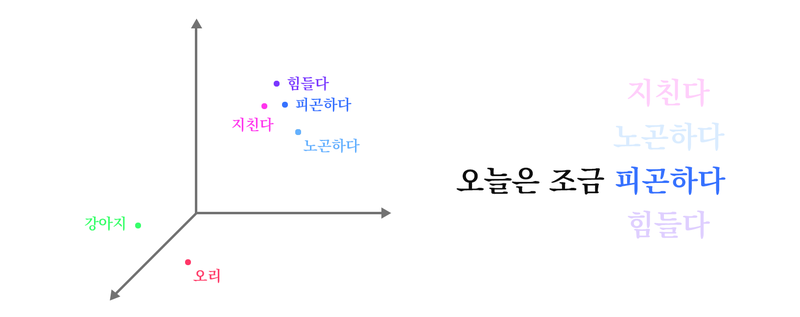   
    
    - gensim 의 most_similar() 함수를 사용할 수 있다. 

- TF-IDF 기반 대체:   

    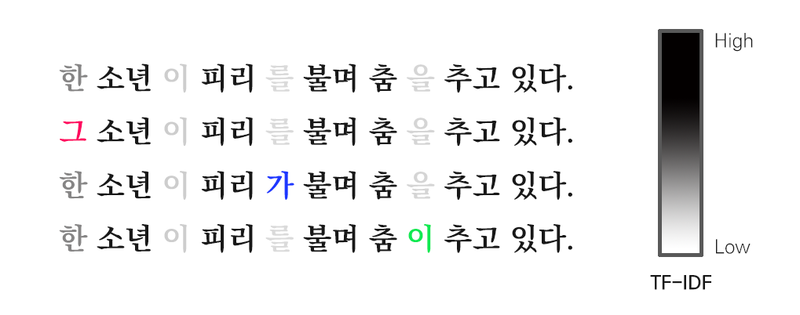  

        - TF-IDF는 여러 문서를 기반으로 단어마다 중요도를 부여하는 알고리즘이다.  
        문서의 핵심이 되는 소년, 피리 같은 단어들은 높은 TF-IDF값을 부여받고, 한,를과 같은 단어들은 낮은 TF-IDF 값을 가지게 된다.   
        이 때, 낮은 TF-IDF 값을 갖는 단어들은 핵심 단어가 아니기 때문에 다른 단어로 대체해도 문맥이 크게 변하지 않는다는 것에 주목한 아이디어이다.

- 역번역:  
    Beam + Noise 가 가장 성능이 좋음  

- 오타 노이즈 추가   
- 공백 노이즈 추가
- 랜덤 유의어 추가: 주어진 문장에서 불용어(Stop word)가 아닌 단어를 랜덤하게 뽑은 후, 해당 단어와 유사한 단어를 골라 문장에 아무렇게나 삽입하는 방식이다. 원본 단어가 손실되지 않는다.

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import re
import os
import random
import math

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(tf.__version__)

2.16.2


In [12]:
zip_path = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True
)

print('슝=3')

슝=3


In [15]:
file_path = os.path.dirname(zip_path)+"/spa-eng/spa.txt"

with open(file_path, "r", encoding="utf-8") as f:
    spa_eng_sentences = f.read().splitlines()

spa_eng_sentences = list(set(spa_eng_sentences)) 
total_sentence_count = len(spa_eng_sentences)
print("Example:", total_sentence_count)

for sen in spa_eng_sentences[0:100][::20]: 
    print(">>", sen)

Example: 118964
>> It's too bad that you couldn't come.	Es una lástima que no puedas venir.
>> They should have the right to decide for themselves.	Deberían tener derecho a decidir por sí mismas.
>> He likes traveling and so do I.	Le gusta viajar. A mí me gusta también.
>> The river is no longer as clean as it used to be.	El río ya no es tan limpio como solía ser.
>> Hunting is prohibited in this area.	En esta área está prohibido cazar.


In [16]:
# Q. 전처리 함수를 만들어 보세요. 아래 기능을 추가해주세요.
def preprocess_sentence(sentence): 
    sentence = sentence.lower()
    sentence = re.sub(r'\s+'," ", sentence)
    sentence = sentence.strip()
    
    return sentence

In [18]:
spa_eng_sentences = list(map(preprocess_sentence, spa_eng_sentences))

- map은 험수와 반복 가능한 개체 (리스트 같은)을 인자로 받아, 반복 가능한 개체의 각 요소에 주어진 함수를 적용함. 

In [19]:
spa_eng_sentences

["it's too bad that you couldn't come. es una lástima que no puedas venir.",
 'have you ever smoked? ¿has fumado alguna vez?',
 "these earphones don't work. estos audífonos no sirven.",
 'he terrified him. él le aterroriza.',
 'part of the story is true. una parte de la historia es cierta.',
 'he took a picture of the koala. él le tomó una foto al koala.',
 'tom heard a noise. tom oyó un ruido.',
 'he wants the most bang for his buck. él quiere el mejor resultado para su dinero.',
 'he was so frightened that he ran for his life. él tenía tanto miedo que corrió por su vida.',
 'not all baby animals are cute. no todas las crías de animales son bonitas.',
 'how annoying! ¡qué rollo!',
 'tell me what you have. dime lo que tienes.',
 'you should not try to force your ideas on others. no está bien intentar imponer las ideas propias a los demás.',
 'none of this was your fault. nada de eso fue culpa tuya.',
 'why would i kill your dog? ¿por qué mataría yo a tu perro?',
 "that's disgusting. es

In [21]:
# 테스트에 사용할 데이터 따로 떼기. 전체 데이터의 0.5%

test_sentence_count = total_sentence_count // 200
print("Test size: ", test_sentence_count)
print("\n")

train_spa_eng_sentences = spa_eng_sentences[:-test_sentence_count]
test_spa_eng_sentences = spa_eng_sentences[-test_sentence_count:]
print("Train Example: ", len(train_spa_eng_sentences))

for sen in train_spa_eng_sentences[0:100][::20]:
    print(">>", sen)
print("\n")

print("Test Example: ", len(test_spa_eng_sentences))

for sen in test_spa_eng_sentences[0:100][::20]:
    print(">>", sen)

Test size:  594


Train Example:  118370
>> it's too bad that you couldn't come. es una lástima que no puedas venir.
>> they should have the right to decide for themselves. deberían tener derecho a decidir por sí mismas.
>> he likes traveling and so do i. le gusta viajar. a mí me gusta también.
>> the river is no longer as clean as it used to be. el río ya no es tan limpio como solía ser.
>> hunting is prohibited in this area. en esta área está prohibido cazar.


Test Example:  594
>> the british withdrew, but attacked again the next year. los británicos se retiraron, pero atacaron de nuevo al año siguiente.
>> i just want to help you relax. solo quiero ayudarte a que te relajes.
>> money doesn't always bring happiness. el dinero no siempre trae felicidad.
>> i'm a great singer. soy un gran cantante.
>> where did you get the idea? ¿dónde obtuviste esa idea?


In [35]:
#영어랑 스페인어 분리해주기
def split_spa_eng_sentences(sentences):
    spa_sentences = []
    eng_sentences = []
    for spa_eng_sentence in sentences:
        if any(punct in spa_eng_sentence for punct in ['.', '!', '?']):
            # 특정 기호를 기준으로 나눕니다.
            parts = re.split(r'(?<=[.!?])', spa_eng_sentence)
            if len(parts) >= 2:
                eng_sentence, spa_sentence = parts[0].strip(), parts[1].strip()
                spa_sentences.append(spa_sentence)
                eng_sentences.append(eng_sentence)
            else:
                print(f"Skipping line (not enough parts after split): {spa_eng_sentence}")
        else:
            print(f"Skipping line (no punctuation found): {spa_eng_sentence}")
    return eng_sentences, spa_sentences


In [34]:
train_eng_sentences, train_spa_sentences = split_spa_eng_sentences(train_spa_eng_sentences)
print(len(train_eng_sentences))
print(train_eng_sentences[0])
print('\n')
print(len(train_spa_sentences))
print(train_spa_sentences[0])

118370
it's too bad that you couldn't come.


118370
es una lástima que no puedas venir.


In [36]:
test_eng_sentences, test_spa_sentences = split_spa_eng_sentences(test_spa_eng_sentences)
print(len(test_eng_sentences))
print(test_eng_sentences[0])
print('\n')
print(len(test_spa_sentences))
print(test_spa_sentences[0])

594
the british withdrew, but attacked again the next year.


594
los británicos se retiraron, pero atacaron de nuevo al año siguiente.


In [39]:
##토큰화
def generate_tokenizer(corpus,
                       vocab_size,
                       lang="spa-eng",
                       pad_id=0,   # pad token의 일련번호
                       bos_id=1,  # 문장의 시작을 의미하는 bos token(<s>)의 일련번호
                       eos_id=2,  # 문장의 끝을 의미하는 eos token(</s>)의 일련번호
                       unk_id=3):   # unk token의 일련번호
    file = "./%s_corpus.txt" % lang
    model = "%s_spm" % lang

    with open(file, 'w', encoding='utf-8') as f:
        for row in corpus: f.write(str(row) + '\n')

    import sentencepiece as spm
    spm.SentencePieceTrainer.Train(
        '--input=./%s --model_prefix=%s --vocab_size=%d'\
        % (file, model, vocab_size) + \
        '--pad_id==%d --bos_id=%d --eos_id=%d --unk_id=%d'\
        % (pad_id, bos_id, eos_id, unk_id)
    )

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('%s.model' % model)

    return tokenizer

print("슝=3")
    

슝=3


In [40]:
VOCAB_SIZE = 20000
tokenizer = generate_tokenizer(train_eng_sentences + train_spa_sentences, VOCAB_SIZE, 'spa-eng')
tokenizer.set_encode_extra_options("bos:eos")  # 문장 양 끝에 <s> , </s> 추가

True

두 언어 사이에 단어 사전을 공유하기로 하였으므로 Encoder와 Decoder의 전용 토크나이저를 만들지 않고, 방금 만들어진 토크나이저를 두 언어 사이에서 공유하게 됩니다.

In [41]:
def make_corpus(sentences, tokenizer):
    corpus = []
    for sentence in sentences:
        tokens = tokenizer.encode_as_ids(sentence)
        corpus.append(tokens)
    return corpus

print('슝=3')


슝=3


In [42]:
eng_corpus = make_corpus(train_eng_sentences, tokenizer)
spa_corpus = make_corpus(train_spa_sentences, tokenizer)

Exception ignored in: <function tqdm.__del__ at 0x000002624D127920>
Traceback (most recent call last):
  File "c:\Users\seowoo kim\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\seowoo kim\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


In [44]:
print(train_eng_sentences[0])
print(eng_corpus[0])
print('\n')
print(train_spa_sentences[0])
print(spa_corpus[0])

it's too bad that you couldn't come.
[1, 27, 7, 11, 190, 488, 31, 12, 136, 35, 7, 17, 132, 0, 2]


es una lástima que no puedas venir.
[1, 25, 41, 4377, 15, 14, 2344, 702, 0, 2]


In [45]:
MAX_LEN = 50
enc_ndarray = tf.keras.preprocessing.sequence.pad_sequences(eng_corpus, maxlen=MAX_LEN, padding='post')
dec_ndarray = tf.keras.preprocessing.sequence.pad_sequences(spa_corpus, maxlen=MAX_LEN, padding='post')

print('슝=3')

슝=3


In [49]:
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((enc_ndarray, dec_ndarray)).batch(batch_size=BATCH_SIZE)

#from_tensor_slices는 enc_ndarray와 dec_ndarray의 각 행(row)을 개별 요소로 분할하여 데이터셋을 생성합니다. 
#그런 다음, batch 메서드를 사용하여 이 데이터셋을 주어진 BATCH_SIZE만큼의 배치로 나눕니다.

In [52]:
# 두 번째와 세 번째 배치를 가져오기
start_index = 1
num_batches = 2
subset = train_dataset.skip(start_index).take(num_batches)

# 데이터셋 출력
for batch in subset:
    print(batch)

(<tf.Tensor: shape=(64, 50), dtype=int32, numpy=
array([[   1,   50,    7, ...,    0,    0,    0],
       [   1,   92,  272, ...,    0,    0,    0],
       [   1,  401,  119, ...,    0,    0,    0],
       ...,
       [   1,   45,  225, ...,    0,    0,    0],
       [   1,   27,    7, ...,    0,    0,    0],
       [   1,    6, 2218, ...,    0,    0,    0]])>, <tf.Tensor: shape=(64, 50), dtype=int32, numpy=
array([[    1,    14,  3280, ...,     0,     0,     0],
       [    1,    18,   435, ...,     0,     0,     0],
       [    1,    79,     7, ...,     0,     0,     0],
       ...,
       [    1,    58,    33, ...,     0,     0,     0],
       [    1,    25,  3029, ...,     0,     0,     0],
       [    1,    57, 11915, ...,     0,     0,     0]])>)
(<tf.Tensor: shape=(64, 50), dtype=int32, numpy=
array([[   1,   45,    7, ...,    0,    0,    0],
       [   1,   45,  318, ...,    0,    0,    0],
       [   1,    9, 1080, ...,    0,    0,    0],
       ...,
       [   1,    6,   52, 

- shape를 잘 보면, 첫 번째 요소는 batch 크기이고, 두 번째 요소는 max_len임을 알 수 있다. 

## 트랜스포머 구현하기

In [85]:
# 1. pos encoding

def positional_encoding(pos, d_model):#d_model 은 vocab 임베딩 차원 수
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [131]:

#2. 마스크 생성하기

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)  #seq에서 0인 곳을 찾고 float32로 cast
    return seq[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1,1,seq_len)
# 이렇게 하는 이유는 이후에 어텐션 스코어 텐서 (batch_size, num_heads, seq_len, seq_len)랑 계산해야 해서이다. 

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)# -1은 하삼각, 0은 상삼각
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src) #(batch_size, 1, 1, src_len)
    dec_enc_mask = generate_padding_mask(src) #(batch_size,1,1,src_len)

    dec_lookahead_mask = generate_lookahead_mask(tf.shape(tgt)[1]) #(tgt_len, tgt_len)
    dec_tgt_padding_mask = generate_padding_mask(tgt)#(batch_size, 1, 1, tgt_len)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask) #(batch_size, 1,tgt_len, tgt_len)

    return enc_mask, dec_enc_mask, dec_mask

 

In [148]:

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)  # Find zeros in seq and cast to float32
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)  # -1 for lower triangle, 0 for upper triangle
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)  # (batch_size, 1, 1, src_len)
    dec_enc_mask = generate_padding_mask(src)  # (batch_size, 1, 1, src_len)

    dec_lookahead_mask = generate_lookahead_mask(tf.shape(tgt)[1])  # (tgt_len, tgt_len)
    dec_tgt_padding_mask = generate_padding_mask(tgt)  # (batch_size, 1, 1, tgt_len)
    
    # Adjusting dec_mask calculation for compatibility with newer TensorFlow versions
    dec_lookahead_mask = tf.cast(dec_lookahead_mask, tf.float32)  # Ensure lookahead mask is float32
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask[tf.newaxis, tf.newaxis, :, :])  # (batch_size, 1, tgt_len, tgt_len)

    return enc_mask, dec_enc_mask, dec_mask


In [149]:
# Multi-head attention

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        
        self.depth = d_model//self.num_heads #각 개별 head가 처리하는 벡터 차원. 이렇게 해서 다양한 어텐션 패턴을 학습할 수 있다.
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)  #선형 결합
    
    def scaled_dot_product_attention(self, Q, K, V, mask): #(batch_size, seq_len, depth)
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)
        
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if mask is not None: scaled_qk += (mask * -1e9)
        
        attentions = tf.nn.softmax(scaled_qk, axis = -1) #axis = -1은 텐서에서 가장 마지막 차원. 즉, 각 쿼리 위치에서 모든 키 위치에 적용
        out = tf.matmul(attentions, V)
        
        return out, attentions
    
    def split_heads(self, x):
        bsz = x.shape[0] #batch_size
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth)) #(batch_size, seq_len, num_heads, depth) #-1은 자동으로 계산된 차원
        split_x = tf.transpose(split_x, perm = [0,2,1,3])
        
        return split_x
    
    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm = [0,2,1,3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))
        
        return combined_x
        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )
        
        out = self.combine_heads(out)
        out = self.linear(out)
        
        return out, attention_weights

In [150]:
#새로 한 MA
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

In [151]:
#Position_wise FFN

class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out
            

In [152]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)#epsilon은 분산 계산에서 매우 작은 값이 더해져 나누기 연산 시 숫자 0이 되는 거 방지

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):#multi-head attention => Q, K, V 텐서 입력으로 받음. 인코더는 이 세 개의 입력이 모두 동일 
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [153]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):  #d_ff는 은닉층의 크기
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn
        

In [154]:
# Encoder 구현

class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [155]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [156]:
# trnasformer 전체 모델 조립하기

class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [157]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)
		
d_model = 512

In [158]:
# Learning Rate Scheduler 구현
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


In [159]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [160]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [161]:
@tf.function
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)
    
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(tgt, predictions)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, enc_attns, dec_attns, dec_enc_attns

In [162]:
EPOCHS = 3

for epoch in range(EPOCHS):
    total_loss = tf.Variable(0.0, dtype=tf.float32)

    dataset_count = tf.data.Dataset.cardinality(train_dataset).numpy()
    
    for batch, (enc_train, dec_train) in enumerate(train_dataset):
        enc_train = tf.convert_to_tensor(enc_train)
        dec_train = tf.convert_to_tensor(dec_train)

        loss, enc_attns, dec_attns, dec_enc_attns = train_step(
            enc_train,
            dec_train,
            transformer,
            optimizer
        )
        
        total_loss.assign_add(loss)
        
        if (batch + 1) % 10 == 0 or (batch + 1) == dataset_count:
            print(f"Epoch {epoch + 1}, Batch {batch + 1}, Loss: {total_loss.numpy() / (batch + 1):.4f}")
    
    print(f"Epoch {epoch + 1} Loss: {total_loss / dataset_count:.4f}")

c:\Users\seowoo kim\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:372: UserWarning: `build()` was called on layer 'encoder_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


ValueError: in user code:

    File "C:\Users\seowoo kim\AppData\Local\Temp\ipykernel_25188\1640147660.py", line 9, in train_step  *
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
    File "c:\Users\seowoo kim\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\seowoo kim\AppData\Local\Temp\ipykernel_25188\2902831234.py", line 59, in call
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
    File "C:\Users\seowoo kim\AppData\Local\Temp\ipykernel_25188\1294809943.py", line 20, in call
        self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)
    File "C:\Users\seowoo kim\AppData\Local\Temp\ipykernel_25188\955978506.py", line 22, in call
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
    File "C:\Users\seowoo kim\AppData\Local\Temp\ipykernel_25188\2716948789.py", line 54, in call
        out, attention_weights = self.scaled_dot_product_attention(
    File "C:\Users\seowoo kim\AppData\Local\Temp\ipykernel_25188\2716948789.py", line 22, in scaled_dot_product_attention
        if mask is not None: scaled_qk += (mask * -1e9)

    ValueError: Exception encountered when calling MultiHeadAttention.call().
    
    [1mDimensions must be equal, but are 50 and 49 for '{{node transformer_5_1/decoder_3_1/decoder_layer_6_1/multi_head_attention_21_1/add}} = AddV2[T=DT_FLOAT](transformer_5_1/decoder_3_1/decoder_layer_6_1/multi_head_attention_21_1/truediv, transformer_5_1/decoder_3_1/decoder_layer_6_1/multi_head_attention_21_1/mul)' with input shapes: [64,8,50,50], [64,1,49,49].[0m
    
    Arguments received by MultiHeadAttention.call():
      • Q=tf.Tensor(shape=(64, 50, 512), dtype=float32)
      • K=tf.Tensor(shape=(64, 50, 512), dtype=float32)
      • V=tf.Tensor(shape=(64, 50, 512), dtype=float32)
      • mask=tf.Tensor(shape=(64, 1, 49, 49), dtype=float32)


In [125]:
import sacrebleu

reference = "많 은 자연어 처리 연구자 들 이 트랜스포머 를 선호 한다".split()
candidate = "적 은 자연어 학 개발자 들 가 트랜스포머 을 선호 한다 요".split()

# sacrebleu expects references and hypothesis to be strings
reference_str = " ".join(reference)
candidate_str = " ".join(candidate)

# Compute BLEU score
bleu = sacrebleu.sentence_bleu(candidate_str, [reference_str])

print("원문:", reference)
print("번역문:", candidate)
print("BLEU Score:", bleu.score)


원문: ['많', '은', '자연어', '처리', '연구자', '들', '이', '트랜스포머', '를', '선호', '한다']
번역문: ['적', '은', '자연어', '학', '개발자', '들', '가', '트랜스포머', '을', '선호', '한다', '요']
BLEU Score: 10.600313379512592


BLEU Score가 50점을 넘는다는 것은 정말 멋진 번역을 생성했다는 의미예요. 

## 회고

1. 나는 아직도 Transformer에 머물러있다,,그런데 왜 자꾸 오류가 날까?? ㅠㅠ 잘..모르겠다....
2. BLEU 버전도 tf 버전에 맞춰야 한다. 의존성 문제 너무 짜증난다 ㅠㅠ